# test dataset analytics

a set of functions for quickly viewing aggregate properties of a MIDI dataset

## parameters
edit these before running

In [ ]:
# filesystem parameters
# INPUT_DIR = "/media/nova/Datasets/maestro/segments"
INPUT_DIR = "../data/datasets/20250110/"
SEGMENT_DIR = INPUT_DIR + "segmented"  # basic segmented files
AUGMENT_DIR = INPUT_DIR + "augmented"  # ^ + all augmentations
OUTPUT_DIR = "../data/tests"
DATASET_NAME = "20250110"

# dataset parameters
NUM_BEATS = 9
MIN_BPM = 50
MAX_BPM = 130

# bounds for outlier detection
OUTLIERS = {
    "min_seg_len": NUM_BEATS * 60 / MAX_BPM
    - 1,  # 9 beats per segment * 60 secs per min / 100 bpm (fastest recording tempo) - 1s for buffer = 4.4s
    "max_seg_len": NUM_BEATS * 60 / MIN_BPM
    + 1,  # 9 beats per segment * 60 secs per min / 50 bpm (slowest recording tempo) + 1s for buffer = 11.8s
    "min_note_len": 0.01,  # 10ms min note len
    "max_note_len": 12,  # 12s max note len
    "min_pitch": 0,  # lowest MIDI note, unusual
    "max_pitch": 127
    - 11,  # within an octave of the highest MIDI note, may cause issues transposing
    "min_vel": 5,  # anything quieter than this is unlikely
    "max_vel": 120,  # anything louder than this is unlikely
}

## imports

In [ ]:
import os
import json
import random
import pretty_midi
import matplotlib.pyplot as plt
from collections import Counter
from rich.progress import (
    Progress,
    SpinnerColumn,
    TimeElapsedColumn,
    MofNCompleteColumn,
)

## functions

In [ ]:
def analyze(folder_path):
    dur_counter = Counter()
    len_counter = Counter()
    pch_counter = Counter()
    phn_counter = Counter()
    vel_counter = Counter()

    outliers = []

    p = Progress(
        SpinnerColumn(),
        *Progress.get_default_columns(),
        TimeElapsedColumn(),
        MofNCompleteColumn(),
        refresh_per_second=0.1,
    )

    with p:
        for dir_path, _, files in os.walk(folder_path):
            scan_task = p.add_task(
                f"scanning {os.path.basename(dir_path)}", total=len(files)
            )
            for file_name in files:
                if file_name.endswith(".mid") or file_name.endswith(".midi"):
                    file_path = os.path.join(dir_path, file_name)

                    try:
                        midi = pretty_midi.PrettyMIDI(file_path)

                        # count segment-level properties
                        # segment length
                        et = midi.get_end_time()
                        len_counter[et] += 1
                        if et <= OUTLIERS["min_seg_len"]:
                            print(
                                f"short segment found w length {et:.03f}s:\t{file_name}"
                            )
                            outliers.append(
                                {
                                    "name": file_name,
                                    "type": "under min segment length",
                                    "value": et,
                                    "path": file_path,
                                }
                            )
                        elif et >= OUTLIERS["max_seg_len"]:
                            print(
                                f"long segment found w length {et:.03f}s:\t{file_name}"
                            )
                            outliers.append(
                                {
                                    "name": file_name,
                                    "type": "over max segment length",
                                    "value": et,
                                    "path": file_path,
                                }
                            )

                        # segment pitch histogram
                        phn = midi.get_pitch_class_histogram()
                        for i, pitch in enumerate(phn):
                            phn_counter[i] += pitch

                        # count note-level properties
                        midi_data = pretty_midi.PrettyMIDI(file_path)
                        for instrument in midi_data.instruments:
                            for note in instrument.notes:
                                # note duration
                                dt = note.end - note.start
                                dur_counter[dt] += 1
                                if dt <= OUTLIERS["min_note_len"]:
                                    print(
                                        f"short note found w note dur {dt:.03f}:\t{file_name}"
                                    )
                                    outliers.append(
                                        {
                                            "name": file_name,
                                            "type": "under min note length",
                                            "value": dt,
                                            "path": file_path,
                                        }
                                    )
                                elif dt >= OUTLIERS["max_note_len"]:
                                    print(
                                        f"long note found w note dur {dt:.03f}:\t{file_name}"
                                    )
                                    outliers.append(
                                        {
                                            "name": file_name,
                                            "type": "over max note length",
                                            "value": dt,
                                            "path": file_path,
                                        }
                                    )
                                # note pitch
                                pch_counter[note.pitch] += 1
                                if note.pitch <= OUTLIERS["min_pitch"]:
                                    print(
                                        f"low note found w pitch {note.pitch}:\t{file_name}"
                                    )
                                    outliers.append(
                                        {
                                            "name": file_name,
                                            "type": "under min pitch",
                                            "value": note.pitch,
                                            "path": file_path,
                                        }
                                    )
                                elif note.pitch >= OUTLIERS["max_pitch"]:
                                    print(
                                        f"high note found w pitch {note.pitch}:\t{file_name}"
                                    )
                                    outliers.append(
                                        {
                                            "name": file_name,
                                            "type": "over max pitch",
                                            "value": note.pitch,
                                            "path": file_path,
                                        }
                                    )
                                # note velocity
                                vel_counter[note.velocity] += 1
                                if note.velocity <= OUTLIERS["min_vel"]:
                                    print(
                                        f"quiet note found w vel {note.velocity:03d}:\t{file_name}"
                                    )
                                    outliers.append(
                                        {
                                            "name": file_name,
                                            "type": "under min velocity",
                                            "value": note.velocity,
                                            "path": file_path,
                                        }
                                    )
                                elif note.velocity >= OUTLIERS["max_vel"]:
                                    print(
                                        f"loud note found w vel {note.velocity:03d}:\t{file_name}"
                                    )
                                    outliers.append(
                                        {
                                            "name": file_name,
                                            "type": "over max velocity",
                                            "value": note.velocity,
                                            "path": file_path,
                                        }
                                    )
                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")
                        outliers.append(
                            {
                                "name": file_name,
                                "type": "file processing error",
                                "value": None,
                                "path": file_path,
                            }
                        )
                        continue
                p.advance(scan_task)
            p.remove_task(scan_task)
    return (
        len_counter,
        pch_counter,
        vel_counter,
        dur_counter,
        phn_counter,
    ), outliers

In [27]:
def plot_histogram(
    histogram,
    save_path,
    show=True,
    grid=False,
    x_label="Time (s)",
    y_label="Count",
    x_tick_labels=None,
    title=None,
) -> None:
    plt.figure(figsize=(10, 6))

    plt.bar(
        list(histogram.keys()), list(histogram.values())
    )  # , width=1.0, edgecolor="black")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale("log")
    plt.grid(grid)

    if title:
        plt.title(title)
    if x_tick_labels:
        plt.xticks(range(len(x_tick_labels)), x_tick_labels)

    plt.savefig(save_path)

    if show:
        plt.show()
    else:
        plt.close()

In [ ]:
def plot_piano_rolls(
    pf_midi: list[str],
    output_path: str,
    main_title: str = f"{DATASET_NAME} Piano Rolls",
) -> None:
    fig, axs = plt.subplots(3, 3, figsize=(15, 10))
    for ax, midi_file in zip(axs.flatten(), pf_midi):
        midi = pretty_midi.PrettyMIDI(midi_file)
        piano_roll = midi.get_piano_roll()
        ax.imshow(piano_roll, aspect="auto", cmap="gray", origin="lower")
        ax.set_title(os.path.basename(midi_file))
        ax.axis("off")

    plt.suptitle(main_title)
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f"{main_title}.png"))
    plt.close()

## go

### calculate

In [ ]:
# parameter verification
if len(os.listdir(INPUT_DIR)) < 1:
    print(f"input directory '{INPUT_DIR}' is empty")
    raise IndexError

output_dir = os.path.join(OUTPUT_DIR, DATASET_NAME)
if os.path.isdir(output_dir):
    print(f"output folder '{output_dir}' already exists, pick a new one")
    raise IsADirectoryError

os.makedirs(output_dir)

In [ ]:
(lc, pc, vc, dc, pn), outliers = analyze(SEGMENT_DIR)

outlier_file = os.path.join(output_dir, "outliers.json")
print(f"{len(outliers)} outliers found, writing out to '{outlier_file}'")
with open(outlier_file, "w") as f:
    json.dump(outliers, f)

### plot

In [ ]:
midi_files = []
for dir_path, _, files in os.walk(AUGMENT_DIR):
    for file_name in files:
        if file_name.endswith(".mid") or file_name.endswith(".midi"):
            midi_files.append(os.path.join(dir_path, file_name))

selected_files = random.sample(midi_files, min(9, len(midi_files)))

plot_piano_rolls(selected_files, output_dir, "Randomly Sampled Segments")

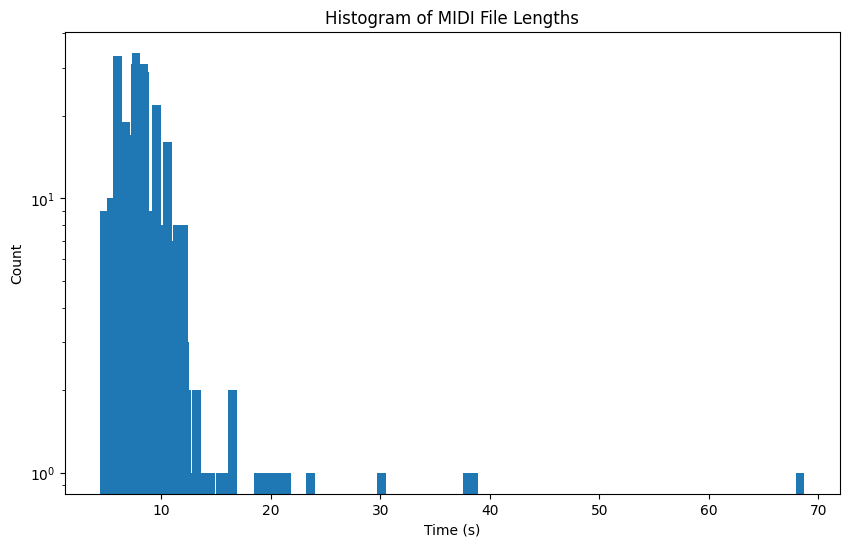

In [ ]:
plot_histogram(
    lc,
    os.path.join(output_dir, "segment_lengths.png"),
    title="Histogram of MIDI File Lengths",
)

In [ ]:
plot_histogram(
    pc,
    os.path.join(output_dir, "pitch_counts.png"),
    x_label="MIDI Pitch",
    title="Histogram of MIDI Note Pitches",
)

In [ ]:
plot_histogram(
    vc,
    os.path.join(output_dir, "velocity_counts.png"),
    x_label="MIDI Velocity",
    title="Histogram of MIDI Note Velocities",
)

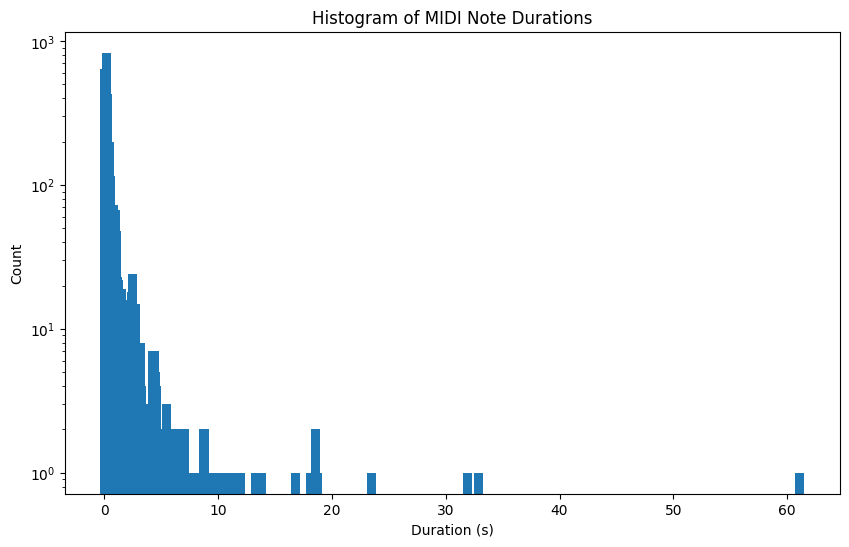

In [29]:
plot_histogram(
    dc,
    os.path.join(output_dir, "duration_counts_log.png"),
    x_label="Duration (s)",
    title="Histogram of MIDI Note Durations",
)

In [ ]:
plot_histogram(
    pn,
    os.path.join(output_dir, "pitch_histogram_counts.png"),
    x_tick_labels=["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"],
    x_label="Note",
    title="Sum of Pitch Histograms",
)

### empty files

In [ ]:
# find empty files
for dir_path, _, files in os.walk(AUGMENT_DIR):
    for file_name in files:
        if file_name.endswith(".mid") or file_name.endswith(".midi"):
            midi = pretty_midi.PrettyMIDI(os.path.join(dir_path, file_name))
            note_count = 0
            for ins in midi.instruments:
                note_count += len(ins.notes)

            if note_count == 0:
                print(f"empty file found: '{file_name}'\tremoving...")
                os.remove(os.path.join(dir_path, file_name))